In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SEIRmodel import SEIRmodel
from scipy import interpolate
from numba import njit
import multidim_stochastic_collocation as msc

In [2]:
def beta_PDF(tao):
    '''
    PDF of given beta distribution

    Arguments:
        tao -- random variable

    Returns:
        probability of tao
    '''
    return (tao-1)*(14-tao)

def beta_CDF(tao):
    '''
    CDF of given beta distribution

    Arguments:
        tao -- random variable

    Returns:
        probability that RV <= tao
    '''
    return (-1/3 * tao**3 + 15/2 * tao**2 - 14 * tao + 41/6) / (2197/6)

# get inverse of beta CDF by means of interpolation
beta_invCDF = interpolate.interp1d(beta_CDF(np.linspace(1,14,1001)),np.linspace(1,14,1001))

def beta_sample():
    '''
        sample from given beta distribution
    '''
    u = np.random.uniform()
    return beta_invCDF(u)

def I_max(R0, T, tao):
    '''
    caculates the quantity of interest max(I(t))

    Arguments:
        R0 -- reproductive number
        T -- incubation period
        tao -- recovery rate

    Returns:
        maximum value of infected for the given parameters
    '''
    return np.max(SEIRmodel(R0, T, tao)[:,2])

def eval_nodes(nodes):
    '''
    evaluates all combinations of the nodes with the original PDEs

    Arguments:
        nodes -- 2D array of the nodes

    Returns:
        array with the quantity of interest for each node
    '''
    nodes = np.copy(nodes)

    # transform nodes to proper interval
    nodes[0,:] = msc.map_val_to_new_interval(nodes[0,:],1.5,3)
    nodes[1,:] = msc.map_val_to_new_interval(nodes[1,:],5,10)
    nodes[2,:] = beta_invCDF(msc.map_val_to_new_interval(nodes[2,:],0,1))
    Imax_at_nodes = []

    # loop over all combinations and calculate the quantity of interest
    for i in range(nodes.shape[1]):
        for j in range(nodes.shape[1]):
            for k in range(nodes.shape[1]):
                Imax_at_nodes.append(I_max(nodes[0,i], nodes[1,j], nodes[2,k]))
    
    return np.array(Imax_at_nodes)

@njit
def surrogate_SEIR(R0_norm, T_norm, tao_norm, Imax_at_nodes, nodes):
    '''
    The surrogate of the SEIR constructed with stochastic collocation

    Arguments:
        R0_norm -- normalized reproductive number
        T_norm -- normalized incubation period
        tao_norm -- normalized recovery rate
        Imax_at_nodes -- array with the quantity of interest for each node
        nodes -- array with the nodes for each dimension

    Returns:
        approximation of SEIR with the given parameters
    '''
    
    # get te lagrange basis function for the nodes in each dimension
    lagrange_base = np.zeros(nodes.shape)
    for i in range(nodes.shape[1]):
        # calculate the Lagrange basis functions
        lagrange_base[0,i] = msc.lagrange_basis(R0_norm, nodes[0], i)
        lagrange_base[1,i] = msc.lagrange_basis(T_norm, nodes[1], i)
        lagrange_base[2,i] = msc.lagrange_basis(tao_norm, nodes[2], i)
    
    # calculate the approximation
    approx = 0
    counter = 0
    for i in range(nodes.shape[1]):
        for j in range(nodes.shape[1]):
            for k in range(nodes.shape[1]):
                approx += Imax_at_nodes[counter] * lagrange_base[0,i] * lagrange_base[1,j] * lagrange_base[2,k]
                counter += 1
                

    return approx

In [3]:
# define the nodes
k = 4; d = 3
nodes = msc.get_clenshawcurtis_collocation_nodes_matrix(k, d)
# calculate the quantities of interest
Imax_at_nodes = eval_nodes(nodes)

In [4]:
# random comparison
R0_norm = np.random.uniform(-1,1)
T_norm = np.random.uniform(-1,1)
tao_norm = np.random.uniform(-1,1)
print('surrogate: I(t)= ', surrogate_SEIR(R0_norm,T_norm,tao_norm,Imax_at_nodes,nodes))

R0 = msc.map_val_to_new_interval(R0_norm,1.5,3)
T = msc.map_val_to_new_interval(T_norm,5,10)
tao = beta_invCDF(msc.map_val_to_new_interval(tao_norm,0,1))
print('model: I(t)', I_max(R0,T,tao))

surrogate: I(t)=  9269.38432274089
model: I(t) 9258.511806673143


In [5]:
# MC sampling
N = 1_000_000
MC_samples = []
for i in range(N):
    R0_norm = np.random.uniform(-1,1)
    T_norm = np.random.uniform(-1,1)
    tao_norm = np.random.uniform(-1,1)
    approx = surrogate_SEIR(R0_norm,T_norm,tao_norm,Imax_at_nodes,nodes) 
    MC_samples.append(approx)

MC_samples = np.array(MC_samples)

Text(0.5, 0, 'max. I(t), 50 bins, N= 1000000')

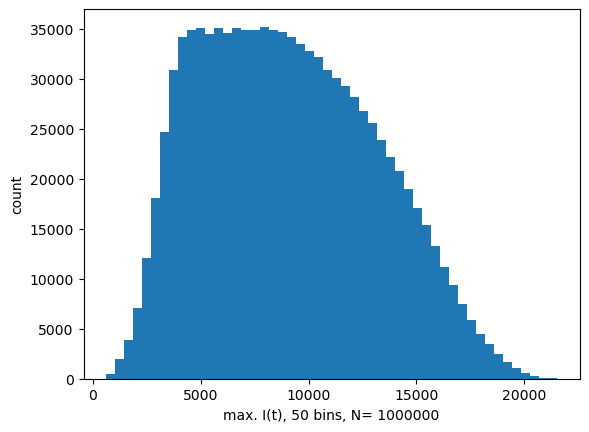

In [6]:
# histogram
nbins = 50
plt.hist(MC_samples, bins=nbins)
plt.ylabel('count')
plt.xlabel('max. I(t), '+str(nbins)+' bins, N= '+str(N))

In [7]:
# mean
np.mean(MC_samples)

9074.061616350999

In [8]:
# standard deviaton
np.std(MC_samples)

4008.68693524286

In [9]:
# probability for I(t) > 15_000
np.count_nonzero(np.where(MC_samples > 15_000)) / N

0.086834